In [ ]:
# do required imports
import difflib
import torch
from torch.autograd import Variable
import torch.nn as nn
import pickle
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2834)
import matplotlib.ticker as mtick
import matplotlib as matplotlib
matplotlib.rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from collections import Counter

In [ ]:
lm = torch.load('model.pt', map_location=lambda storage, loc: storage)

In [ ]:
# calculate word frequencies
train_data = []
with open('train.txt', 'r', encoding='utf-8') as infile:
    for line in infile:
        for word in line.split():
            train_data.append(word)
counter = Counter(train_data)

In [ ]:
# Load dictionary word --> id 
dictionary = pickle.load(open('dict', 'rb'))

# set the maximum sequence length
max_seq_len = 50

# function to transform sentence into word id's and put them in a pytorch Variable
# NB Assumes the sentence is already tokenised!
def tokenise(sentence, dictionary):
    words = sentence.split(' ')
    l = len(words)
    assert l <= max_seq_len, "sentence too long"
    token = 0
    ids = torch.LongTensor(l)

    for word in words:
        try:
            ids[token] = dictionary.word2idx[word]
        except KeyError:
            print( word)
            raw_input()
            ids[token] = dictionary.word2idx['<unk>']
        token += 1
    return ids

In [ ]:
# load pytorch softmax function
softmax = nn.Softmax()

def evaluate(model, dictionary, sentence, check_words):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    
    # number of tokens (= output size)
    ntokens = len(dictionary)
    hidden = model.init_hidden(1)
    
    # tokenise the sentence, put in torch Variable
    test_data = tokenise(sentence, dictionary)
    input_data = Variable(test_data, volatile=True)

    # run the model, compute probabilities by applying softmax
    output, hidden = model(input_data, hidden)
    output_flat = output.view(-1, ntokens)
    logits = output[-1, :]
    sm = softmax(logits).view(ntokens)
    
    # get probabilities of certain words by looking up their
    # indices and print them
    def get_prob(word):
        return sm[dictionary.word2idx[word]].data[0]

    #print (sentence, '\n')
    #print ('\n'.join(
    #        ['%s: %f' % (word, get_prob(word)) for word in check_words]
    #        ) )
    return  [{word : get_prob(word)} for word in check_words]

In [ ]:
# Compose sentence prefixes with frequent words.
# The sentence prefixes are intended to test intervening nouns.


NN = ['company', 'year', 'market', 'share', 'stock', 'system', 'president', 'business', 
      'quarter', 'government', 'time', 'week', 'price', 'group', 'interest',
      'industry', 'unit','month', 'rate', 'investment', 'state', 'producer', 'income', 
      'program', 'bank', 'part', 'plan', 'sale', 'issue', 'tax', 'way', 'loss', 'executive', 'day', 'bid', 'data', 'line','hour', 'plant', 'concern']

NNS = ['companies', 'years', 'markets', 'shares', 'stocks', 'systems', 'presidents', 
       'businesses', 'quarters', 'governments', 'times', 'weeks', 'prices', 'groups', 'interests', 'industries', 
       'units', 'months', 'rates', 'investments', 'states', 'producers', 'incomes', 'programs', 'banks', 'parts', 'plans', 
      'sales', 'issues', 'taxes', 'ways', 'losses', 'executives', 'days', 'bids', 'data', 'lines', 'hours', 'plants', 'concerns',]

VBP = ['are', 'have', 'do', 'say', 'think', 'want', 'expect', 'include', 'ask', 
       'make', 'need', 'know', 'see', 'get', 'seem', 'remain', 'continue', 'show', 'buy', 
       'feel', 'go', 'sell', 'take', 'use', 'plan', 'look', 'tend', 'hope', 'argue', 'give',
       'pay', 'appear', 'suggest', 'fear', 'find', 'come', 'offer', 'contend', 'agree', 'provide']

VBZ = ['is', 'has', 'does', 'says', 'thinks', 'wants', 'expects', 'includes', 'asks', 'makes',
      'needs', 'knows', 'sees', 'gets', 'seems', 'remains', 'continues', 'shows', 'buys', 'feels', 'goes', 'sells',
      'takes', 'uses', 'plans', 'looks', 'tends', 'hopes', 'argues', 'gives', 'pays', 'appears', 'suggests', 'fears',
      'finds', 'comes', 'offers', 'contends', 'agrees', 'provides']

attractor_helpers = ['in the', 'by the', 'close to the', 'of the', 'at the', 'and not the', 'without']


In [ ]:
def calculate_error_rate(sentences):
    result = calculate_errors(sentences)
    #print(result)
    return 1- sum(result)/len(result)
    
def calculate_errors(sentences):
    return [calculate_error(s) for s in sentences]

def calculate_error(sentence):
    return 1 if is_correct_prediction(sentence[0], sentence[1], sentence[2]) else 0 

def is_correct_prediction(sentence, check_words, correct_word):
    predictions = evaluate(lm, dictionary, sentence, check_words)
    words,preds = zip(*list(map(lambda x: list(x.items())[0],predictions)))
    predicted_word = words[np.argmax(preds)]
    return predicted_word == correct_word

def prob_ratio(sent):
    sentence, check_words, correct_word = sent[0], sent[1], sent[2]
    predictions = evaluate(lm, dictionary, sentence, check_words)
    words,preds = zip(*list(map(lambda x: list(x.items())[0],predictions)))
    #return log ratio
    #print(words)
    #return np.log(preds[0]/preds[1])
    return preds[0] / (preds[0] + preds[1])

In [ ]:
# Compose sentence prefixes with frequent words with one and without attractors

def gen_simple_case_matrix(NN, NNS, VBP, VBZ):
    assert(len(VBP) == len(VBZ))
    nouns = NN + NNS
    noun_count = len(nouns)
    verb_count = len(VBP)
    result = []
    result_ratio = []
    for index_noun in range(noun_count):
        row = []
        row_ratio = []
        for index_verb in range(verb_count):
            correct = VBZ[index_verb] if index_noun < len(NN) else VBP[index_verb]
            sentence = (f"the {nouns[index_noun]}", [VBP[index_verb], VBZ[index_verb]], correct)
            #row.append(sentence)
            row.append(calculate_error(sentence))
            row_ratio.append(prob_ratio(sentence))
        result.append(row)
        result_ratio.append(row_ratio)
    return result,result_ratio

In [ ]:
# simple cases: nouns x verbs results, 0 = error, 1 = correct
# first half of the rows are singular nouns,
# second half are plural nouns
n = 40

# matrix indicationg erros, matrix indicating error ratio
# NOUN x VERB, first half of the rows are singular nouns 
# 1 = correct 0 = error
noun_verb_matrix_errors,noun_verb_matrix_ratio = np.array(gen_simple_case_matrix(NN[0:n], NNS[0:n], VBP[0:n], VBZ[0:n]))

In [17]:
# Todo sort columns and rows and make sense of it (by looking at frequencies)

# matrix indicating 'singular' prediction (1=singular, 0 = plural)
noun_verb_matrix_plural_prediction = noun_verb_matrix_errors.copy()
noun_verb_matrix_plural_prediction[n:] = np.array(noun_verb_matrix_plural_prediction[n:] <1,dtype=int)
# sort columns (verbs) by their preference for singular prediction
noun_verb_matrix_plural_prediction_sorted_idx_col = np.argsort(noun_verb_matrix_plural_prediction.sum(axis=0))
noun_verb_matrix_plural_prediction_sorted_col = noun_verb_matrix_plural_prediction[:, noun_verb_matrix_plural_prediction_sorted_idx_col]

# split in NN and NNS
matrix_NN = noun_verb_matrix_plural_prediction_sorted_col[:n]
matrix_NNS = noun_verb_matrix_plural_prediction_sorted_col[n:]

# sort rows by their preference for singular prediction
matrix_NN_sorted_idx_row = np.argsort(-matrix_NN.sum(axis=1))
matrix_NN_sorted_row = matrix_NN[matrix_NN_sorted_idx_row,:]
matrix_NNS_sorted_idx_row = np.argsort(-matrix_NNS.sum(axis=1))
matrix_NNS_sorted_row = matrix_NNS[matrix_NNS_sorted_idx_row,:]

#concatenate matrices
matrix = np.concatenate((matrix_NN_sorted_row, matrix_NNS_sorted_row),axis=0)

# NOUN x VERB, first half of the rows are singular nouns (NN) second half are plural nouns (NNS)
# 1 = plural prediction, 0 = singular prediction
# columns are sorted as follows: 
#   verb with preference for singular (VBZ) ... verb with preference for plural (VBP)
# rows are sorted as follows: 
#   singular noun (NN) correctly predicted singular most of the time
#   ...
#   singular noun (NN) incorrectly predicted plural often
#   plural noun (NNS) incorrectly predicted singular often
#   ...
#   plural noun (NNS) correctly predicted plural most of the time



(80, 40)


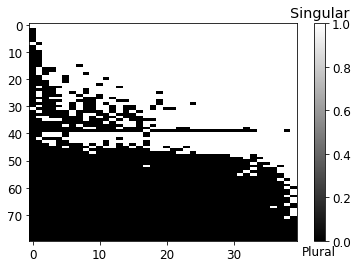

In [18]:
print(matrix.shape)
plt.imshow(matrix, cmap=cm.gray,aspect='auto')
clb = plt.colorbar()
clb.ax.set_title('Singular')
clb.ax.set_xlabel('Plural')
plt.show()
plt.imsave('matrix_plot.png',matrix, cmap=cm.gray)

In [19]:
# IDEA: 
# Color code verb plurality ratios, i.e. Count(produce)/(Count(produces) + Count(produce)) 
# and print below diagram as some sort of 'x-axis'

vector_verbs = []
for i in range(n):
    vector_verbs.append(counter[VBP[i]] / (counter[VBP[i]] + counter[VBZ[i]]))
vector_verbs = np.array(vector_verbs)

# sort after singularity matrix column order
vector_verbs = vector_verbs[noun_verb_matrix_plural_prediction_sorted_idx_col]

# plt.imshow([vector_verbs,vector_verbs], cmap=cm.seismic)
# clb = plt.colorbar()
# clb.ax.set_title('Plural')
# clb.ax.set_xlabel('Singular')
# plt.show()
# plt.imsave('vector_verbs.png',[vector_verbs,vector_verbs], cmap=cm.seismic)

# We see that verbs with a low plurality rate (blue) tend to predict singlar (left)
# and that verbs with a high plurality rate (red) tend to predict plural (right)
# but this is not always the case

#TODO: better plot (?)
#   x-axis plurality rate, 
#   y-axis number of plural predictions (for plurals and for singulars) 

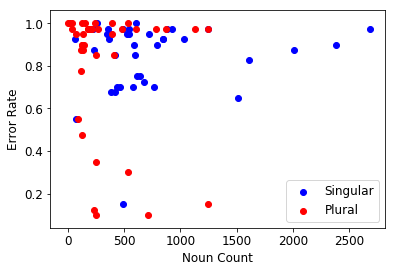

In [33]:
# Color code noun counts, i.e. Count(company)
# and print at the left of the diagram as some sort of 'y-axis'
# sort after index NN col
nouns_freq = []
for i in range(n):
    nouns_freq.append(counter[NN[i]])
for i in range(n):
    nouns_freq.append(counter[NNS[i]])
nouns_freq = np.array(nouns_freq)


error_rate_nouns_NN = []
error_rate_nouns_NNS = []
for row in noun_verb_matrix_errors[:n]:
    error_rate_nouns_NN.append(sum(row)/len(row))
for row in noun_verb_matrix_errors[n:]:
    error_rate_nouns_NNS.append(sum(row)/len(row))
plt.scatter(nouns_freq[:n], error_rate_nouns_NN, color='b', label='Singular')
plt.scatter(nouns_freq[n:], error_rate_nouns_NNS, color='r',label='Plural')
plt.legend()
# Title: 
plt.xlabel('Noun Count')
plt.ylabel('Error Rate')
plt.savefig('noun_freq_error_rate.png')
plt.show()


# What we hoped to see is that the nouns in the middle (i.e. the nouns where a lot of errors were made) 
# had a low count. This is not clear from the picture though.
# What we do see is that plurals tend to have lower count than singulars,
# which may or may not explain the slightly higher error rate for plurals

In [34]:
i2w = np.vectorize(lambda i: NN[i] if i < n else NNS[i-n])
sorted_nouns = i2w(row_indices)
for i,w in enumerate(sorted_nouns):
    print(i,w, matrix[i,:].mean(), nouns_freq[i])

# 1 = all predictions singular, 0 = all predictions plural
# We see that the singular word 'income' seems to be miscounted as plural (0.15)
# We see a lot of plural words that seem to be miscounted (40 - 47)
# We do not see a clear relation with frequencies

0 plant 1.0 2680
1 industry 1.0 2379
2 company 0.975 2005
3 line 0.975 1511
4 issue 0.975 1611
5 system 0.975 360
6 president 0.975 1246
7 government 0.975 1031
8 unit 0.975 791
9 group 0.975 885
10 bid 0.95 847
11 plan 0.95 720
12 month 0.95 767
13 concern 0.95 928
14 week 0.95 679
15 time 0.925 602
16 business 0.925 547
17 producer 0.925 546
18 bank 0.925 579
19 day 0.925 614
20 quarter 0.9 644
21 year 0.9 64
22 program 0.9 492
23 data 0.875 588
24 market 0.875 846
25 executive 0.85 461
26 sale 0.85 525
27 stock 0.825 419
28 investment 0.75 489
29 state 0.75 437
30 interest 0.725 416
31 tax 0.7 385
32 price 0.7 601
33 part 0.7 363
34 rate 0.7 381
35 way 0.675 236
36 loss 0.675 228
37 share 0.65 70
38 hour 0.55 262
39 income 0.15 347
40 weeks 0.9 870
41 months 0.9 1241
42 data 0.875 480
43 years 0.85 1246
44 days 0.7 609
45 times 0.65 252
46 hours 0.525 22
47 ways 0.45 246
48 taxes 0.225 41
49 systems 0.15 40
50 plans 0.15 250
51 lines 0.125 250
52 parts 0.125 785
53 investments 0.1 1

0 buys buy 0.95 0.962818003914
1 thinks think 0.75 0.877005347594
2 shows show 0.7125 0.708074534161
3 plans plan 0.6625 0.560298826041
4 looks look 0.6125 0.770408163265
5 gets get 0.6 0.876363636364
6 takes take 0.575 0.842105263158
7 feels feel 0.575 0.857142857143
8 offers offer 0.575 0.851711026616
9 uses use 0.5625 0.871428571429
10 sells sell 0.5625 0.886486486486
11 needs need 0.55 0.717948717949
12 gives give 0.5375 0.778846153846
13 fears fear 0.5375 0.587412587413
14 hopes hope 0.5375 0.484210526316
15 sees see 0.525 0.882911392405
16 finds find 0.525 0.874316939891
17 goes go 0.4875 0.774928774929
18 pays pay 0.475 0.938875305623
19 knows know 0.4625 0.845283018868
20 includes include 0.45 0.6
21 does do 0.45 0.658203125
22 seems seem 0.4375 0.457777777778
23 makes make 0.4375 0.770883054893
24 appears appear 0.4375 0.503144654088
25 comes come 0.4125 0.71511627907
26 provides provide 0.4125 0.701492537313
27 continues continue 0.4125 0.725333333333
28 wants want 0.4125 0.6

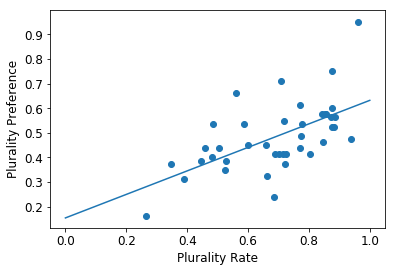

In [48]:
plurality_rate = []
plurality_pref = []

for i,w in enumerate(noun_verb_matrix_plural_prediction_sorted_idx_col):
    print(i,VBZ[w],VBP[w], 1-matrix[:,i].mean(), vector_verbs[i])
    plurality_rate.append(vector_verbs[i])
    plurality_pref.append(1-matrix[:,i].mean())
x = np.arange(0,1.1,0.1)
fit = np.polyfit(plurality_rate,plurality_pref,1)
fit_fn = np.poly1d(fit) 

plt.plot(x,fit_fn(x))
plt.xlabel('Plurality Rate')
plt.ylabel('Plurality Preference')
plt.scatter(plurality_rate,plurality_pref)
plt.savefig('lin_reg.pdf')
plt.show()

# 1 = all predictions singular, 0 = all predictions plural
# We see that the singular word 'income' seems to be miscounted as plural (0.15)
# We see a lot of plural words that seem to be miscounted (40 - 47)
# We do not see a clear relation with frequencies


# low plurality rate = low probability to predic plural

In [ ]:
# IDEA: 
# Create the same diagram for the infrequent nouns. 
# Presumably they are more likely to follow verb preferences, can we see that in the shape?

# Try also to sort the colomns using the column sorting indexes as in the figure above 
# (instead of using the sum criterion).
# Presumably the verbs have the same preferences, can we see that in the shape?


In [39]:
# Todo sort columns and rows and make sense of it (by looking at frequencies)

# matrix indicating 'singular' prediction (1=singular, 0 = plural)
noun_verb_matrix_plural_ratio = noun_verb_matrix_ratio.copy()
# f = np.vectorize(lambda x: 0 if x == 1 else 1)
# noun_verb_matrix_singular_prediction[n:] = f(noun_verb_matrix_ratio[n:])
# noun_verb_matrix_singular_prediction # NOUN x VERB, 1 = singular prediction, 0 = plural prediction

# sort columns (verbs) by their preference for singular prediction
noun_verb_matrix_plural_ratio_sorted_idx_col = np.argsort(-noun_verb_matrix_plural_ratio.sum(axis=0))
noun_verb_matrix_plural_ratio_sorted_col = noun_verb_matrix_plural_ratio[:, noun_verb_matrix_plural_ratio_sorted_idx_col]

# split in NN and NNS
matrix_NN_ratio = noun_verb_matrix_plural_ratio_sorted_col[:n]
matrix_NNS_ratio = noun_verb_matrix_plural_ratio_sorted_col[n:]

# sort rows by their preference for singular prediction
matrix_NN_ratio_sorted_idx_row = np.argsort(matrix_NN_ratio.sum(axis=1))
matrix_NN_ratio_sorted_row = matrix_NN_ratio[matrix_NN_ratio_sorted_idx_row,:]
matrix_NNS_ratio_sorted_idx_row = np.argsort(matrix_NNS_ratio.sum(axis=1))
matrix_NNS_ratio_sorted_row = matrix_NNS_ratio[matrix_NNS_ratio_sorted_idx_row,:]

#concatenate matrices
matrix_ratio = np.concatenate((matrix_NN_ratio_sorted_row, matrix_NNS_ratio_sorted_row),axis=0)

# NOUN x VERB, first half of the rows are singular nouns (NN) second half are plural nouns (NNS)
# 1 = singular prediction, 0 = plural prediction
# columns are sorted as follows: 
#   verb with preference for singular (VBZ) ... verb with preference for plural (VBP)
# rows are sorted as follows: 
#   singular noun (NN) correctly predicted singular most of the time
#   ...
#   singular noun (NN) incorrectly predicted plural often
#   plural noun (NNS) incorrectly predicted singular often
#   ...
#   plural noun (NNS) correctly predicted plural most of the time




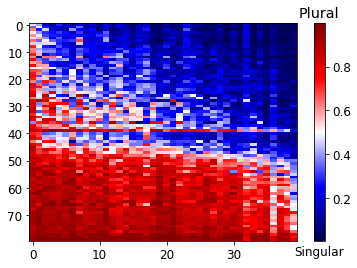

In [47]:
matrix_ratio_big = np.zeros(np.array(matrix_ratio.shape) * 10)

for j in range(matrix_ratio.shape[0]):
    for k in range(matrix_ratio.shape[1]):
        matrix_ratio_big[j * 10: (j+1) * 10, k * 10: (k+1) * 10] = matrix_ratio[j, k]

plt.imshow(matrix_ratio, cmap=cm.seismic,aspect='auto')
clb = plt.colorbar()
clb.ax.set_title('Plural')
clb.ax.set_xlabel('Singular')
plt.savefig('matrix_plot_ratio.pdf')
plt.show()
